# A Chatbot using Langgraph(GRAPH API) 

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
   

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

### initialize the model

In [4]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="openai/gpt-oss-20b")
llm
#------OR--------

# from langchain.chat_models import init_chat_model
# llm = init_chat_model("groq:gpt-oss-20b")
# llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000151FD575BE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000151FD5767B0>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
# Node functionality : chatbot
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [6]:
#add stategraph
graph_builder=StateGraph(State)
#add node
graph_builder.add_node("llmchatbot",chatbot)
#add edge
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

# comlile the graph
graph=graph_builder.compile()

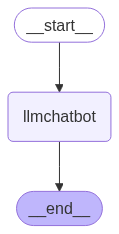

In [7]:
## visulaize the graph
from IPython.display import display,Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass
    

In [8]:
graph.invoke({"messages":"hello, how are you?"})

{'messages': [HumanMessage(content='hello, how are you?', additional_kwargs={}, response_metadata={}, id='9b915a3c-4a64-4ef7-8c29-2bd9246b87d6'),
  AIMessage(content='Hello! I’m doing great—thanks for asking. How can I help you today?', additional_kwargs={'reasoning_content': 'User greeting. Simple.'}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 77, 'total_tokens': 110, 'completion_time': 0.029317668, 'prompt_time': 0.004948024, 'queue_time': 0.045637276, 'total_time': 0.034265692}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_ebaf47239f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--5501dd6c-602f-420f-a06d-753620ab850e-0', usage_metadata={'input_tokens': 77, 'output_tokens': 33, 'total_tokens': 110})]}

## Chatbot with Tool

In [9]:
from langchain_tavily import TavilySearch

Search=TavilySearch(number_of_results=1)
Search.invoke("what is a port number?")

{'query': 'what is a port number?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Port_(computer_networking)',
   'title': 'Port (computer networking) - Wikipedia',
   'content': 'A port is uniquely identified by a number, the **port number**, associated with the combination of a transport protocol and the network IP address. A process "Process (computing)") associates its input or output channels via an internet socket, which is a type of file descriptor, associated with a transport protocol, a network address such as an IP address, and a port number. The document promised a resolution of the conflicts based on a standard that Postel had published in May 1972 in RFC 349, in which he first proposed official assignments of port numbers to network services and suggested a dedicated administrative function, which he called a *czar*, to maintain a registry. *Internet Assigned Numbers Authority (IANA) Procedures for the Man

In [10]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b



In [11]:
tools=[Search,multiply]     #one is tavily tool and another is custom function
tools

[TavilySearch(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'), api_base_url=None)),
 <function __main__.multiply(a: int, b: int) -> int>]

In [12]:
# BIND the LLM with tools
llm_with_tools = llm.bind_tools(tools)   

In [13]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000151FD575BE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000151FD5767B0>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A l

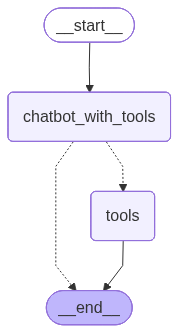

In [14]:
# state graph with tools
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# node definition
def chatbot_with_tools(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Graph 
builder = StateGraph(State)
# add nodes
builder.add_node("chatbot_with_tools",chatbot_with_tools)
builder.add_node("tools",ToolNode(tools))

## add edges
builder.add_edge(START,"chatbot_with_tools")
builder.add_conditional_edges("chatbot_with_tools",tools_condition)
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END

builder.add_edge("tools",END)

# compile the graph
graph=builder.compile()

#visulalize the graph
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [15]:
# getting response
response = graph.invoke({"messages":"what is recent ai news"})
response

{'messages': [HumanMessage(content='what is recent ai news', additional_kwargs={}, response_metadata={}, id='171d9c2f-b851-4460-bf5d-69012a1ccc14'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User: "what is recent ai news". We need to provide recent AI news. We need to browse. Use tavily_search with query "recent AI news". Probably want time_range "day" or "week". We\'ll search.', 'tool_calls': [{'id': 'fc_f719e255-65ab-483d-a149-c858df62e4ed', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","time_range":"week","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1390, 'total_tokens': 1479, 'completion_time': 0.079362107, 'prompt_time': 0.090855456, 'queue_time': 0.052177343, 'total_time': 0.170217563}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_b30a5b183c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logp

In [16]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.google/technology/ai/google-ai-updates-august-2025/", "title": "The latest AI news we announced in August - Google Blog", "content": "# The latest AI news we announced in August\\n\\nSep 10, 2025\\n\\nHere’s a recap of some of our biggest AI updates from August, including an expansion of AI Mode in Search, the newest AI-powered Pixel devices and Google DeepMind’s “Nano Banana.”\\n\\nSuperG\\n\\n## General summary [...] From Google\'s labs, AI news takes flight,  \\nWith updates shared for all to see the light.  \\nNew search modes bloom, with agents at your call,  \\nAnd Pixel\'s power answers every thrall.\\n\\nDeepMind\'s creations, images so grand,  \\nWhile students learn, with AI close at hand.  \\nNew coding tools, for tasks both big and small,  \\nAnd Genie\'s world, where dreams can enthrall. [...] August was bananas. We had an AI Mode in Search expansion, a

In [17]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_f719e255-65ab-483d-a149-c858df62e4ed)
 Call ID: fc_f719e255-65ab-483d-a149-c858df62e4ed
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.google/technology/ai/google-ai-updates-august-2025/", "title": "The latest AI news we announced in August - Google Blog", "content": "# The latest AI news we announced in August\n\nSep 10, 2025\n\nHere’s a recap of some of our biggest AI updates from August, including an expansion of AI Mode in Search, the newest AI-powered Pixel devices and Google DeepMind’s “Nano Ba

In [18]:

response=graph.invoke({"messages":"What is 5 multiply by 2 and then multiply 9. use tools "})
for m in response['messages']:
    m.pretty_print()



================================ Human Message =================================

What is 5 multiply by 2 and then multiply 9. use tools 
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_6e70d9b5-f9d3-4a6b-bb42-01da7d1a3f5d)
 Call ID: fc_6e70d9b5-f9d3-4a6b-bb42-01da7d1a3f5d
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


## ReAct Agent 🤖

### The LLM is the final decision maker. whether to call a tool again or to END it.In ReAct architecture the tool returns its response back to the LLM for futher process and conclusion.

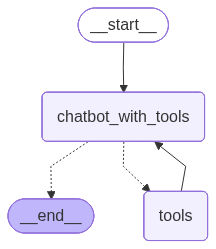

In [19]:
# state graph with tools
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# node definition
def chatbot_with_tools(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Graph 
builder = StateGraph(State)
# add nodes
builder.add_node("chatbot_with_tools",chatbot_with_tools)
builder.add_node("tools",ToolNode(tools))

## add edges
builder.add_edge(START,"chatbot_with_tools")
builder.add_conditional_edges("chatbot_with_tools",tools_condition)
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END

builder.add_edge("tools","chatbot_with_tools")

# compile the graph
graph=builder.compile()

#visulalize the graph
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [20]:

response=graph.invoke({"messages":"What is latest AI/ML news and then 5 multiply by 2 "})
for m in response['messages']:
    m.pretty_print()



================================ Human Message =================================

What is latest AI/ML news and then 5 multiply by 2 
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_e16f1173-7f43-4ba9-958a-cf4312dfb1a0)
 Call ID: fc_e16f1173-7f43-4ba9-958a-cf4312dfb1a0
  Args:
    include_favicon: False
    include_images: False
    query: latest AI/ML news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI/ML news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.rcrwireless.com/20250915/5g/beyond-bandwidth-ai", "title": "Beyond bandwidth: Why AI forces a rethink of telecom reliability (Reader Forum) - RCR Wireless", "score": 0.529191, "published_date": "Mon, 15 Sep 2025 14:47:36 GMT", "content": "Image 3: CoreWeave AI\n\nImage: RCR Wireless New

In [21]:
response=graph.invoke({"messages":"Hello my name is john"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is john
================================== Ai Message ==================================

Hello John! 👋 How can I help you today?


In [22]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()



================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don’t have that information. If you let me know, I’ll remember it for our conversation.


## Adding Memory  
- After executing each action, the agent observes the results and saves relevant information in its memory

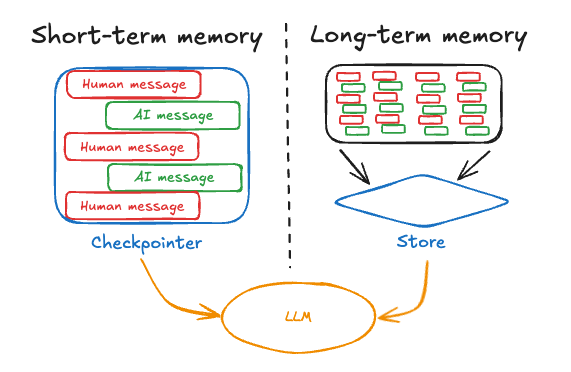

### The only important modification is adding a node to load memories BEFORE calling the agent for the first time.

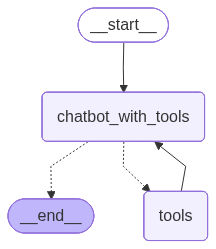

In [23]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# node definition
def chatbot_with_tools(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Graph 
builder = StateGraph(State)
# add nodes
builder.add_node("chatbot_with_tools",chatbot_with_tools)
builder.add_node("tools",ToolNode(tools))

## add edges
builder.add_edge(START,"chatbot_with_tools")
builder.add_conditional_edges("chatbot_with_tools",tools_condition)
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END

builder.add_edge("tools","chatbot_with_tools")

# compile the graph
graph=builder.compile(checkpointer=memory)

#visulalize the graph
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [24]:
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({"messages":"Hello my name is john"},config)
response

{'messages': [HumanMessage(content='Hello my name is john', additional_kwargs={}, response_metadata={}, id='9893b748-7f44-41ed-9192-1cde60bc0bf8'),
  AIMessage(content='Hello John! How can I help you today?', additional_kwargs={'reasoning_content': 'User says "Hello my name is john". Probably wants a response. No request for function. Just greet.'}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 1390, 'total_tokens': 1432, 'completion_time': 0.037387838, 'prompt_time': 0.091044451, 'queue_time': 0.053009278, 'total_time': 0.128432289}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_a5ac2a5d7b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--065a3558-8715-45d1-9000-947d5b08a1b9-0', usage_metadata={'input_tokens': 1390, 'output_tokens': 42, 'total_tokens': 1432})]}

In [25]:
response = graph.invoke({"messages":"what is my name"},config)
response["messages"][-1].content

'Your name is John.'

### ✅ Memory successfully added via checkpointer

## Streaming 

In [26]:

input = {"messages":"what is docker and how it is used?"}
config={"configurable":{"thread_id":"2"}}
events = graph.stream(input,config,stream_mode="values")

for event in events:
    print(event)

{'messages': [HumanMessage(content='what is docker and how it is used?', additional_kwargs={}, response_metadata={}, id='14c0fc34-990e-40ac-b426-8af7735cfea4')]}
{'messages': [HumanMessage(content='what is docker and how it is used?', additional_kwargs={}, response_metadata={}, id='14c0fc34-990e-40ac-b426-8af7735cfea4'), AIMessage(content='**Docker** is a platform that simplifies the development, deployment, and operation of applications by using *containers*. Think of a container as a lightweight, portable, and self‑contained environment that packages an application together with everything it needs to run—code, runtime, system libraries, and settings—so it behaves the same on any machine.\n\n---\n\n## 1. What’s a Docker Container?\n\n| Feature | What it means |\n|---------|---------------|\n| **Isolation** | Each container runs in its own namespace, so processes, files, and network interfaces are separate from the host and from other containers. |\n| **Lightweight** | Containers shar

In [27]:

input = {"messages":"what is MCP?"}
config={"configurable":{"thread_id":"2"}}
events = graph.stream(input,config,stream_mode="values")

for event in events:
    print(event["messages"])

[HumanMessage(content='what is docker and how it is used?', additional_kwargs={}, response_metadata={}, id='14c0fc34-990e-40ac-b426-8af7735cfea4'), AIMessage(content='**Docker** is a platform that simplifies the development, deployment, and operation of applications by using *containers*. Think of a container as a lightweight, portable, and self‑contained environment that packages an application together with everything it needs to run—code, runtime, system libraries, and settings—so it behaves the same on any machine.\n\n---\n\n## 1. What’s a Docker Container?\n\n| Feature | What it means |\n|---------|---------------|\n| **Isolation** | Each container runs in its own namespace, so processes, files, and network interfaces are separate from the host and from other containers. |\n| **Lightweight** | Containers share the host OS kernel; they don’t need a full virtual machine. They’re typically tens of megabytes, not gigabytes. |\n| **Fast** | Starting or stopping a container is almost in

In [28]:
# import asyncio
input = {"messages":"yoo! how are you ?"}
events = graph.astream_events(input,config,version="v2")

async for event in events:
    print(event)
    

{'event': 'on_chain_start', 'data': {'input': {'messages': 'yoo! how are you ?'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '3d3fccdb-cb33-418d-8da8-34d0907991e5', 'metadata': {'thread_id': '2'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='what is docker and how it is used?', additional_kwargs={}, response_metadata={}, id='14c0fc34-990e-40ac-b426-8af7735cfea4'), AIMessage(content='**Docker** is a platform that simplifies the development, deployment, and operation of applications by using *containers*. Think of a container as a lightweight, portable, and self‑contained environment that packages an application together with everything it needs to run—code, runtime, system libraries, and settings—so it behaves the same on any machine.\n\n---\n\n## 1. What’s a Docker Container?\n\n| Feature | What it means |\n|---------|---------------|\n| **Isolation** | Each container runs in its own namespace, so processes, files, and network int

In [29]:
# import asyncio
input = {"messages":"explain xgboost ?"}
events = graph.astream_events(input=input,config=config,version="v2")

async for event in events:
    if event['event']=="on_chat_model_stream":
        print(event['data']["chunk"].content, end="",flush=True)
    

## XGBoost – A Quick‑but‑Comprehensive Guide

### 1. What is XGBoost?

**XGBoost** (“Extreme Gradient Boosting”) is an optimized, scalable, and production‑ready implementation of the gradient‑boosting decision tree algorithm.  
- **Library**: Open‑source (C++ core, Python, R, Java, Scala, Julia, etc.).  
- **Goal**: Build powerful predictive models by iteratively adding weak learners (decision trees) that correct the errors of previous ones.  
- **Why “Extreme”?** It adds a host of engineering tricks (parallel tree construction, cache‑friendly data layout, out‑of‑core computation, regularization, etc.) that make it faster, memory‑efficient, and often more accurate than vanilla gradient boosting.

---

### 2. Core Idea: Gradient Boosting

| Step | What Happens | Why It Helps |
|------|--------------|--------------|
| **1. Start with a base model** (usually a constant prediction) | Provides a starting point. | Sets a baseline error. |
| **2. Compute residuals (errors)** | `r_i = y_i - f(